# Bacteria vs. virus CNN + Unet Masks

In [1]:
import pandas as pd
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os
import cv2
from pathlib import Path
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import activations
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, Callback
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization, AveragePooling2D, Conv2D, MaxPool2D, Activation, GlobalAveragePooling2D
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import plot_confusion_matrix

In [2]:
# Config
IMG_SIZE = 64
BATCH_SIZE=32
train_path = 'data/chest-x-ray/train/PNEUMONIA'
test_path = 'data/chest-x-ray/test/'
val_path = 'data/chest-x-ray/val/'

train_mask_path = 'data/chest-x-ray/masks/train/'

## 1 Data preparation

In [3]:
def load_images_from_folder(img_folder, masks_folder):
    tmp_df = pd.DataFrame(columns = ['img', 'label', 'mask'])
    
    # IMGs
    for filename in os.listdir(img_folder):
        # print(label_folder)
        img_path = str(img_folder)+'/'+str(filename)

        # do not use label_folder, instead use filename to determine 
        # wether the pneumonia is bacteria or virus
        label = str(filename).split("_")[1]
        # print(label)

        # normal file ending is jpEg...
        filename_wo_ending = filename.split('.jpeg')[0]
        mask_path = str(masks_folder)+'/PNEUMONIA/'+str(filename_wo_ending) + '_predmask.jpg'

        if img_path is not None:
            tmp_df = tmp_df.append({'img': img_path, 'label': label, 'mask': mask_path}, ignore_index=True)

    return tmp_df

In [4]:
df_train = load_images_from_folder(train_path, train_mask_path)
# df_val = load_images_from_folder(val_path)
# df_test = load_images_from_folder(test_path)

In [5]:
df_train

,img,label,mask
0,data/chest-x-ray/train/PNEUMONIA/person1000_ba...,bacteria,data/chest-x-ray/masks/train//PNEUMONIA/person...
1,data/chest-x-ray/train/PNEUMONIA/person1000_vi...,virus,data/chest-x-ray/masks/train//PNEUMONIA/person...
2,data/chest-x-ray/train/PNEUMONIA/person1001_ba...,bacteria,data/chest-x-ray/masks/train//PNEUMONIA/person...
3,data/chest-x-ray/train/PNEUMONIA/person1002_ba...,bacteria,data/chest-x-ray/masks/train//PNEUMONIA/person...
4,data/chest-x-ray/train/PNEUMONIA/person1003_ba...,bacteria,data/chest-x-ray/masks/train//PNEUMONIA/person...
...,...,...,...
3870,data/chest-x-ray/train/PNEUMONIA/person99_viru...,virus,data/chest-x-ray/masks/train//PNEUMONIA/person...
3871,data/chest-x-ray/train/PNEUMONIA/person9_bacte...,bacteria,data/chest-x-ray/masks/train//PNEUMONIA/person...
3872,data/chest-x-ray/train/PNEUMONIA/person9_bacte...,bacteria,data/chest-x-ray/masks/train//PNEUMONIA/person...
3873,data/chest-x-ray/train/PNEUMONIA/person9_bacte...,bacteria,data/chest-x-ray/masks/train//PNEUMONIA/person...


In [6]:
print('=== Data: ===')
print('Train:', len(df_train))
# print('Val:', len(df_val))
# print('Test:', len(df_test))

=== Data: ===
Train: 3875


In [7]:
df_train['label'].replace(
    to_replace='bacteria',
    value=0,
    inplace=True
)
df_train['label'].replace(
    to_replace='virus',
    value=1,
    inplace=True
)

In [8]:
##df_train_test = df_train
#df_train_test.drop(df_train_test.tail( round(2/3 * len(df_train_test[df_train_test.label == 1])) ).index,inplace=True)

In [9]:
#df_train_test

In [10]:
#df_train = df_train_test

In [11]:
df_train = df_train.sample(frac=1, random_state=200).reset_index(drop=True)

In [12]:
len(df_train[df_train.label == 0])

2530

In [13]:
len(df_train[df_train.label == 1])

1345

## 2 Data generator

In [14]:
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, df, batch_size=32, shuffle=True):
        self.batch_size = batch_size
        self.df = df
        self.indices = self.df.index.tolist()
        self.shuffle = shuffle

    def __len__(self):
        return len(self.indices) // self.batch_size

    def __getitem__(self, index):
        indexes = self.indices[index * self.batch_size:(index + 1) * self.batch_size]
        batch = [self.indices[k] for k in indexes]
        X, y = self.__get_data(batch)
        return np.array(X), np.array(y)

    def on_epoch_end(self):
        # Todo: Fix?
        # self.indexes = np.arange(len(self.indices))
        if self.shuffle == True:
            np.random.shuffle(self.indices)    

    def __get_data(self, batch):
        X_img_paths = self.df['img']
        X_mask_paths = self.df['mask']
        Y = self.df['label'].iloc[batch].to_numpy()
        
        X_imgs = []
        X_masks = []

        for i in range(0, len(batch)):
            img = cv2.resize(cv2.imread(str(X_img_paths.iloc[batch[i]]), cv2.IMREAD_GRAYSCALE), (IMG_SIZE, IMG_SIZE))
            mask = cv2.resize(cv2.imread(str(X_mask_paths.iloc[batch[i]]), cv2.IMREAD_GRAYSCALE), (IMG_SIZE, IMG_SIZE))
            X_imgs.append(img)
            X_masks.append(mask)

        return np.stack((X_imgs, X_masks), axis=3), Y

In [15]:
train_generator = DataGenerator(df_train, batch_size=32, shuffle=True)

## 3 Model training

In [20]:
model = Sequential()
model.add(Conv2D(32, (3,3), padding = "same", input_shape=(IMG_SIZE,IMG_SIZE,2)))
model.add(Activation(activations.relu))
model.add(Conv2D(32, (3,3), padding = "same"))
model.add(Activation(activations.relu))
model.add(MaxPool2D(pool_size = (3, 3)))
model.add(Dropout(0.2))

model.add(Conv2D(64, (3,3), padding = "same", input_shape=(IMG_SIZE,IMG_SIZE,2)))
model.add(Activation(activations.relu))
model.add(Conv2D(128, (2,2), padding = "same"))
model.add(Activation(activations.relu))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(64, (3,3), padding = "same", input_shape=(IMG_SIZE,IMG_SIZE,2)))
model.add(Activation(activations.relu))
model.add(Conv2D(128, (2,2), padding = "same"))
model.add(Activation(activations.relu))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(64, (3,3), padding = "same", input_shape=(IMG_SIZE,IMG_SIZE,2)))
model.add(Activation(activations.relu))
model.add(Conv2D(128, (2,2), padding = "same"))
model.add(Activation(activations.relu))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(256))
model.add(Activation(activations.relu))
model.add(Dropout(0.5))
model.add(Dense(512))
model.add(Activation(activations.relu))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer = Adam(learning_rate=0.0001), loss = 'binary_crossentropy', metrics = ['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 64, 64, 32)        608       
_________________________________________________________________
activation_14 (Activation)   (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 64, 64, 32)        9248      
_________________________________________________________________
activation_15 (Activation)   (None, 64, 64, 32)        0         
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 21, 21, 32)        0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 21, 21, 32)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 21, 21, 64)       

In [17]:
early_stop = EarlyStopping(monitor='val_acc', patience=5, mode='max') 
callbacks_list = [early_stop]

In [21]:
history = model.fit(train_generator, 
                    steps_per_epoch=len(train_generator),
                    epochs=10, 
                    # callbacks=callbacks_list,
                    verbose = True)

Epoch 1/10
121/121 [==============================] - 15s 122ms/step - loss: 0.8989 - accuracy: 0.5842
Epoch 2/10
121/121 [==============================] - 15s 123ms/step - loss: 0.6631 - accuracy: 0.6317
Epoch 3/10
121/121 [==============================] - 15s 122ms/step - loss: 0.6596 - accuracy: 0.6356
Epoch 4/10
121/121 [==============================] - 15s 122ms/step - loss: 0.6547 - accuracy: 0.6506
Epoch 5/10
121/121 [==============================] - 15s 123ms/step - loss: 0.6535 - accuracy: 0.6498
Epoch 6/10
121/121 [==============================] - 15s 124ms/step - loss: 0.6548 - accuracy: 0.6508
Epoch 7/10
121/121 [==============================] - 15s 124ms/step - loss: 0.6510 - accuracy: 0.6513
Epoch 8/10
121/121 [==============================] - 15s 124ms/step - loss: 0.6523 - accuracy: 0.6519
Epoch 9/10
121/121 [==============================] - 15s 124ms/step - loss: 0.6497 - accuracy: 0.6534
Epoch 10/10
121/121 [==============================] - 15s 127ms/step - l

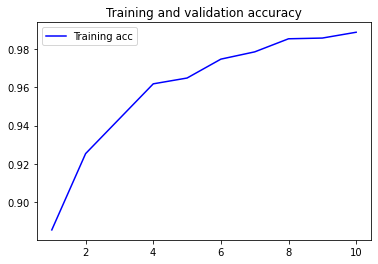

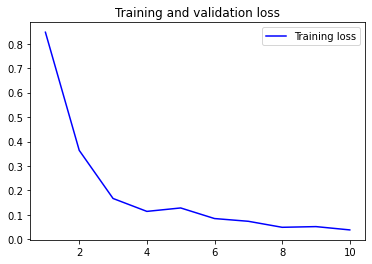

In [185]:
acc = history.history['accuracy']
#val_acc = history.history['val_accuracy']
loss = history.history['loss']
#val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'blue', label='Training acc')
#plt.plot(epochs, val_acc, 'red', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'blue', label='Training loss')
#plt.plot(epochs, val_loss, 'red', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

## 4 Model evaluation

In [186]:
# Evaluate the model on the test data using `evaluate`
print('\n# Evaluate on test data')
results = model.evaluate(test_generator)
print('test loss, test acc:', results)


# Evaluate on test data


NameError: name 'test_generator' is not defined

In [52]:
test_steps_per_epoch = np.math.ceil(test_generator.samples / test_generator.batch_size)
predictions = model.predict(test_generator, steps=test_steps_per_epoch)
# Get most likely class
predicted_classes = np.round(predictions)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [53]:
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())   

In [54]:
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)

              precision    recall  f1-score   support

      NORMAL       0.97      0.82      0.89       168
   PNEUMONIA       0.91      0.99      0.95       303

    accuracy                           0.93       471
   macro avg       0.94      0.90      0.92       471
weighted avg       0.93      0.93      0.93       471



In [55]:
y_true = test_generator.classes
y_pred = predictions > 0.5

In [56]:
# https://www.kaggle.com/grfiv4/plot-a-confusion-matrix/data
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

In [57]:
y_pred = np.round(predictions)
cm = confusion_matrix(test_generator.classes, y_pred)

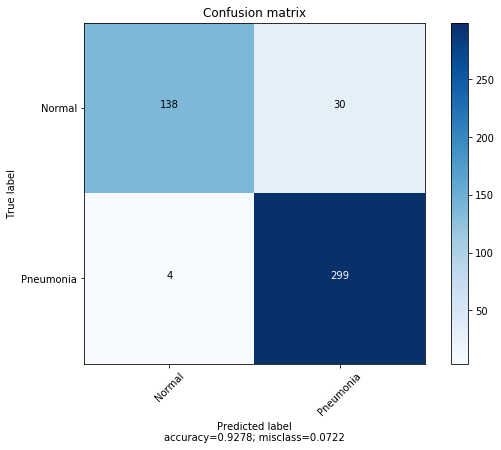

In [58]:
plot_confusion_matrix(cm, ['Normal', 'Pneumonia'], normalize=False)